# Credit Card Fraud Detection

## Problem Statement

Fraudulent activities have increased severalfold, with around 52,304 cases of credit/debit card fraud reported in FY'19 alone. Due to this steep increase in banking frauds, it is the need of the hour to detect these fraudulent transactions in time in order to help consumers as well as banks, who are losing their credit worth each day. Every fraudulent credit card transaction that occur is a direct financial loss to the bank as the bank is responsible for the fraud transactions as well it also affects the overall customer satisfaction adversely.


## Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

The data set that you will be working on during this project was obtained from Kaggle. It contains thousands of individual transactions that took place over a course of two days and their respective labels.

As you saw, the data set includes credit card transactions made by European cardholders over a period of two days in September 2013. Out of a total of 2,84,807 transactions, 492 were fraudulent. This data set is highly unbalanced, with the positive class (frauds) accounting for just 0.172% of the total transactions. The data set has also been modified with Principal Component Analysis (PCA) to maintain confidentiality. Apart from ‘time’ and ‘amount’, all the other features (V1, V2, V3, up to V28) are the principal components obtained using PCA. The feature 'time' contains the seconds elapsed between the first transaction in the data set and the subsequent transactions. The feature 'amount' is the transaction amount. The feature 'class' represents class labelling, and it takes the value 1 in cases of fraud and 0 in others.

The distribution plots of the variables were Gaussian, which might indicate the effects of transformations that had already occurred on the data set. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
# Import:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#install scikit-optimize
!pip install scikit-optimize
from skopt import BayesSearchCV


# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Exploratory data analysis

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#observe the different feature type present in the data
# Check for shape (i.e. row and number of columns)
df.shape

(284807, 31)

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# Check for non-nullable and nullable columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Here we will observe the distribution of our classes

In [8]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

print('----- Classes -----')
print(classes)
print('\n----- Normal share -----')
print(normal_share)
print('\n----- Fraud share -----')
print(fraud_share)

----- Classes -----
0    284315
1       492
Name: Class, dtype: int64

----- Normal share -----
99.82725143693798

----- Fraud share -----
0.1727485630620034


In [9]:
# correlation matrix
cor = df.corr()
cor

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


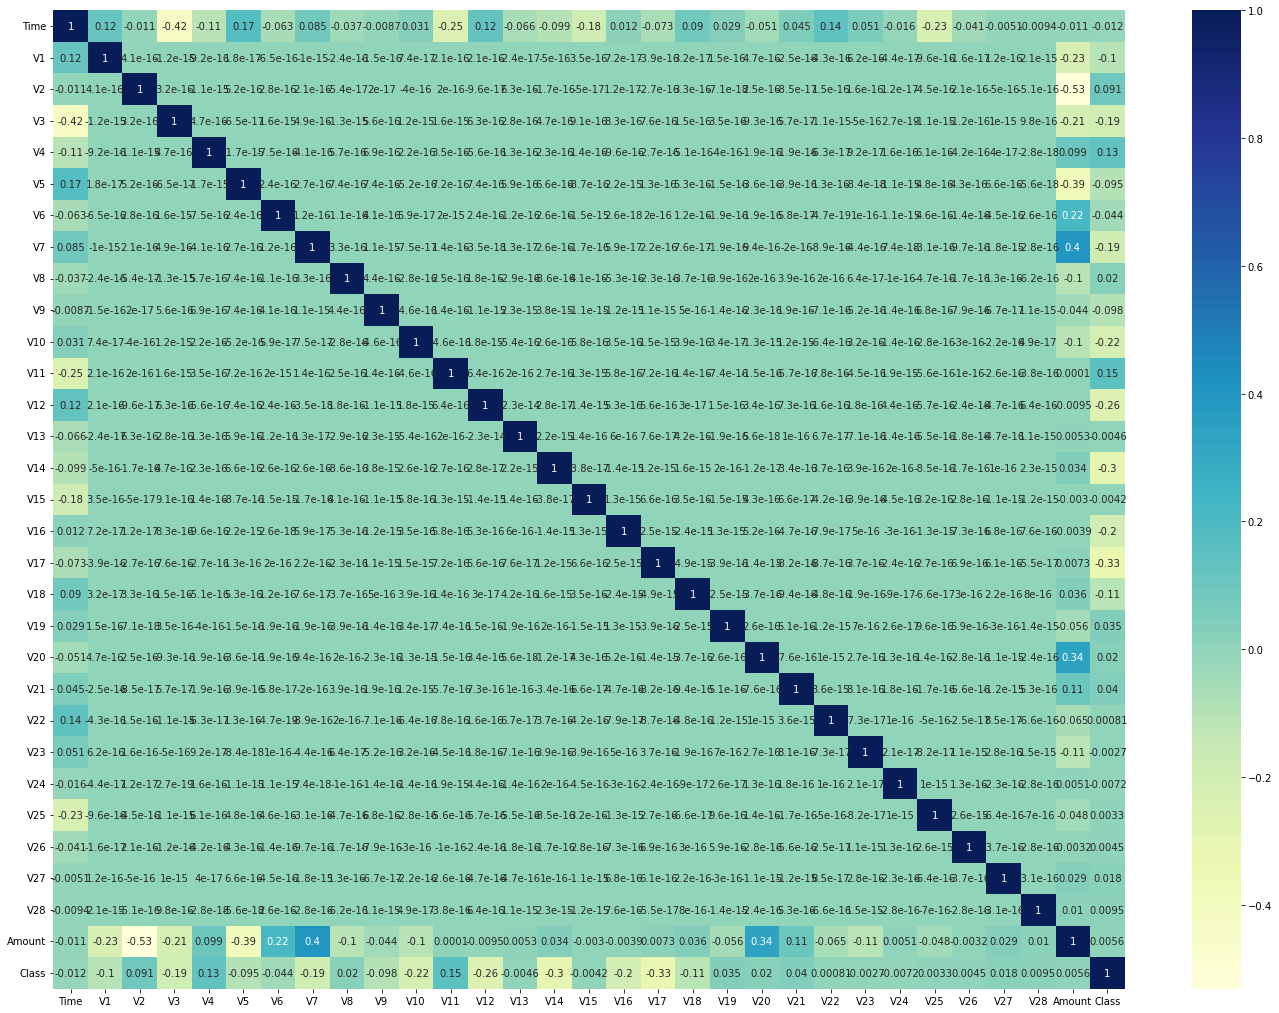

In [10]:
# correlations on a heatmap
plt.figure(figsize=(24,18))
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

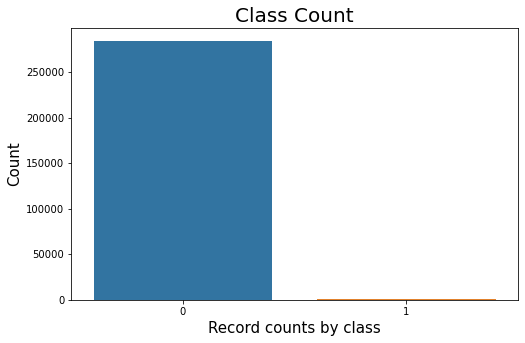

In [12]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plt.figure(figsize=(8,5))
sns.countplot(df['Class'])
plt.title("Class Count", fontsize=20)
plt.xlabel("Record counts by class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

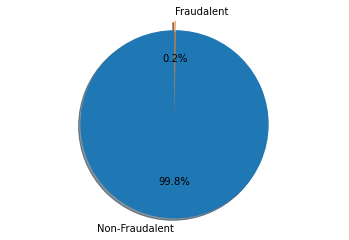

In [13]:
# ratio in terms of percentage
labels = 'Non-Fraudalent', 'Fraudalent'
sizes = [normal_share, fraud_share]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### Observation:
- Approximately 99.8% of the data is non-fradultent
- Approximately 0.2% of the data is fradulent ( i.e. 492 out of 284807 credit card transactions)

In [14]:
# Create a scatter plot to observe the distribution of classes with time
Delta_Time = pd.to_timedelta(df['Time'], unit='s')
#Create derived columns Mins and hours
df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_Min'] = (Delta_Time.dt.components.minutes).astype(int)

Text(0.5, 1.05, 'Time vs Class Distribution')

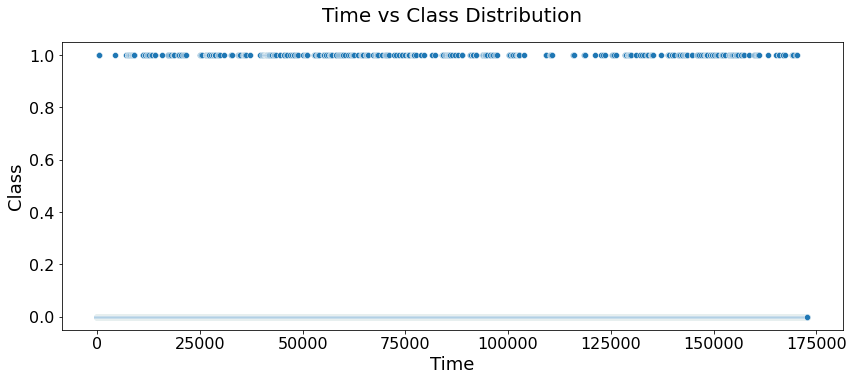

In [16]:
fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set2')
plt.subplot(3,1,1)
sns.scatterplot(x=df['Time'], y='Class', palette=cmap, data=df)
plt.xlabel('Time', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Time vs Class Distribution', size=20, y=1.05)

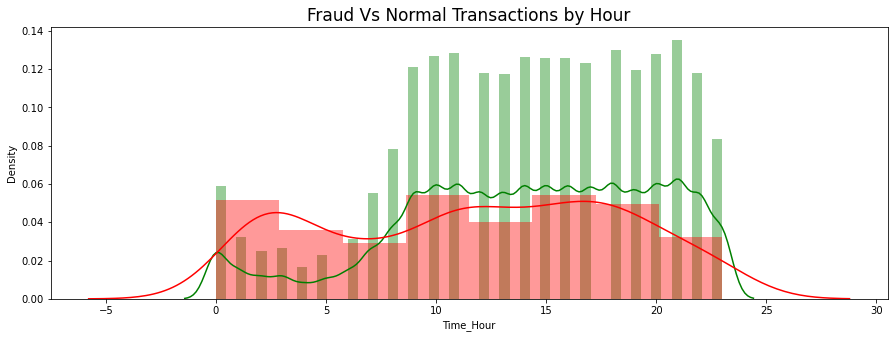

In [17]:
#The fraud Vs normal trasaction by hour
plt.figure(figsize=(15,5))
sns.distplot(df[df['Class'] == 0]["Time_Hour"], color='green')
sns.distplot(df[df['Class'] == 1]["Time_Hour"], color='red')
plt.title('Fraud Vs Normal Transactions by Hour', fontsize=17)
plt.show()

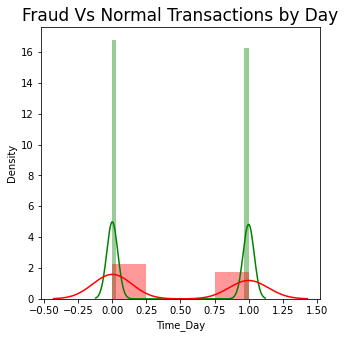

In [18]:
#The fraud Vs normal trasaction by day
plt.figure(figsize=(5,5))
sns.distplot(df[df['Class'] == 0]["Time_Day"], color='green')
sns.distplot(df[df['Class'] == 1]["Time_Day"], color='red')
plt.title('Fraud Vs Normal Transactions by Day', fontsize=17)
plt.show()

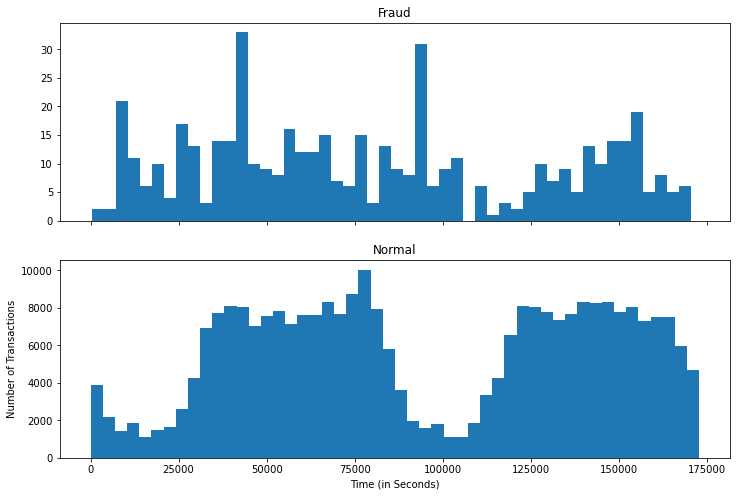

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))

bins = 50
ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

In [23]:
# Create a scatter plot to observe the distribution of classes with Amount
df_Fraud = df[df['Class'] == 1]
df_Regular = df[df['Class'] == 0]

# Fraud Transaction Amount Statistics
print('------ Fraud transaction amount statistics ------')
print(df_Fraud["Amount"].describe())

print('\n------ Regular transaction amount statistics ------')
print(df_Regular["Amount"].describe())

------ Fraud transaction amount statistics ------
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

------ Regular transaction amount statistics ------
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Text(0.5, 1.05, 'Amount vs Class Distribution')

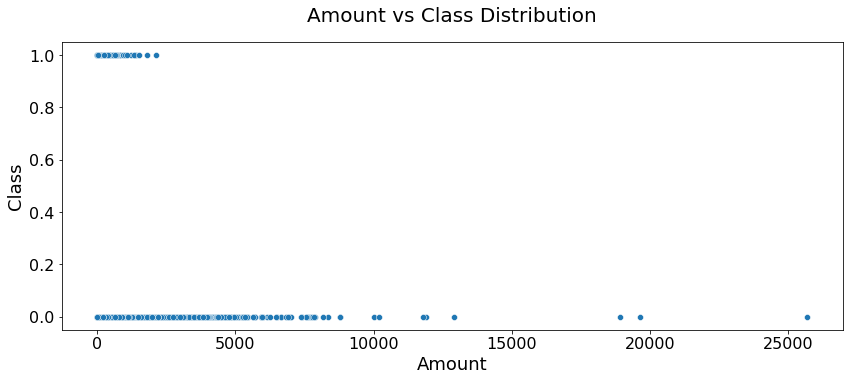

In [24]:
# Amount vs class distribution
fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set1')

# PLot the relation between the variables:
plt.subplot(3,1,1)
sns.scatterplot(x=df['Amount'], y='Class', palette=cmap, data=df)
plt.xlabel('Amount', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Amount vs Class Distribution', size=20, y=1.05)

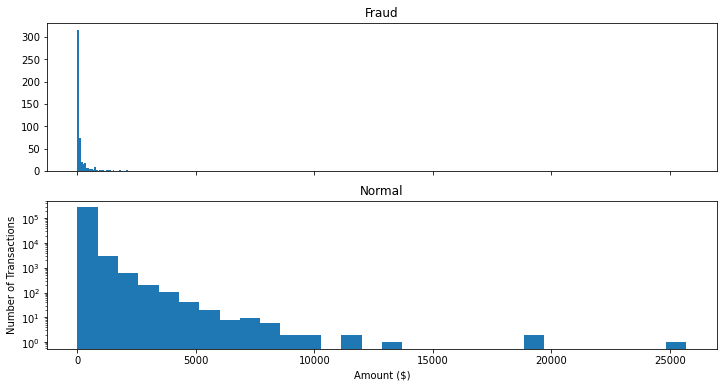

In [27]:
# Fraud vs Normal amount distribution
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

### Check for co-relation between variables to understand their relationship and sort the values in descending order

In [30]:
print("Most important features relative to target variable Class")

corr_initial = df.corr()['Class']
corr_initial = pd.DataFrame(corr_initial)

# correct column label from SalePrice to correlation
corr_initial.columns = ["Correlation"]
corr_initial2 = corr_initial.sort_values(by=['Correlation'], ascending=False)
corr_initial2.head(10)

Most important features relative to target variable Class


,Correlation
Class,1.000000
V11,0.154876
V4,0.133447
V2,0.091289
V21,0.040413
V19,0.034783
V20,0.020090
V8,0.019875
V27,0.017580
V28,0.009536


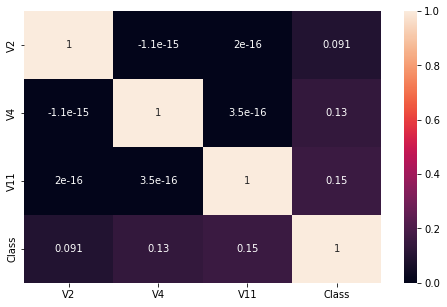

In [33]:
# Check for correlation between variables where class > 0.09
top_feature = cor.index[abs(cor['Class'] > 0.09)]
plt.subplots(figsize=(8, 5))
top_corr = df[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

## Boxplot to understand the distribution of numercial attributes

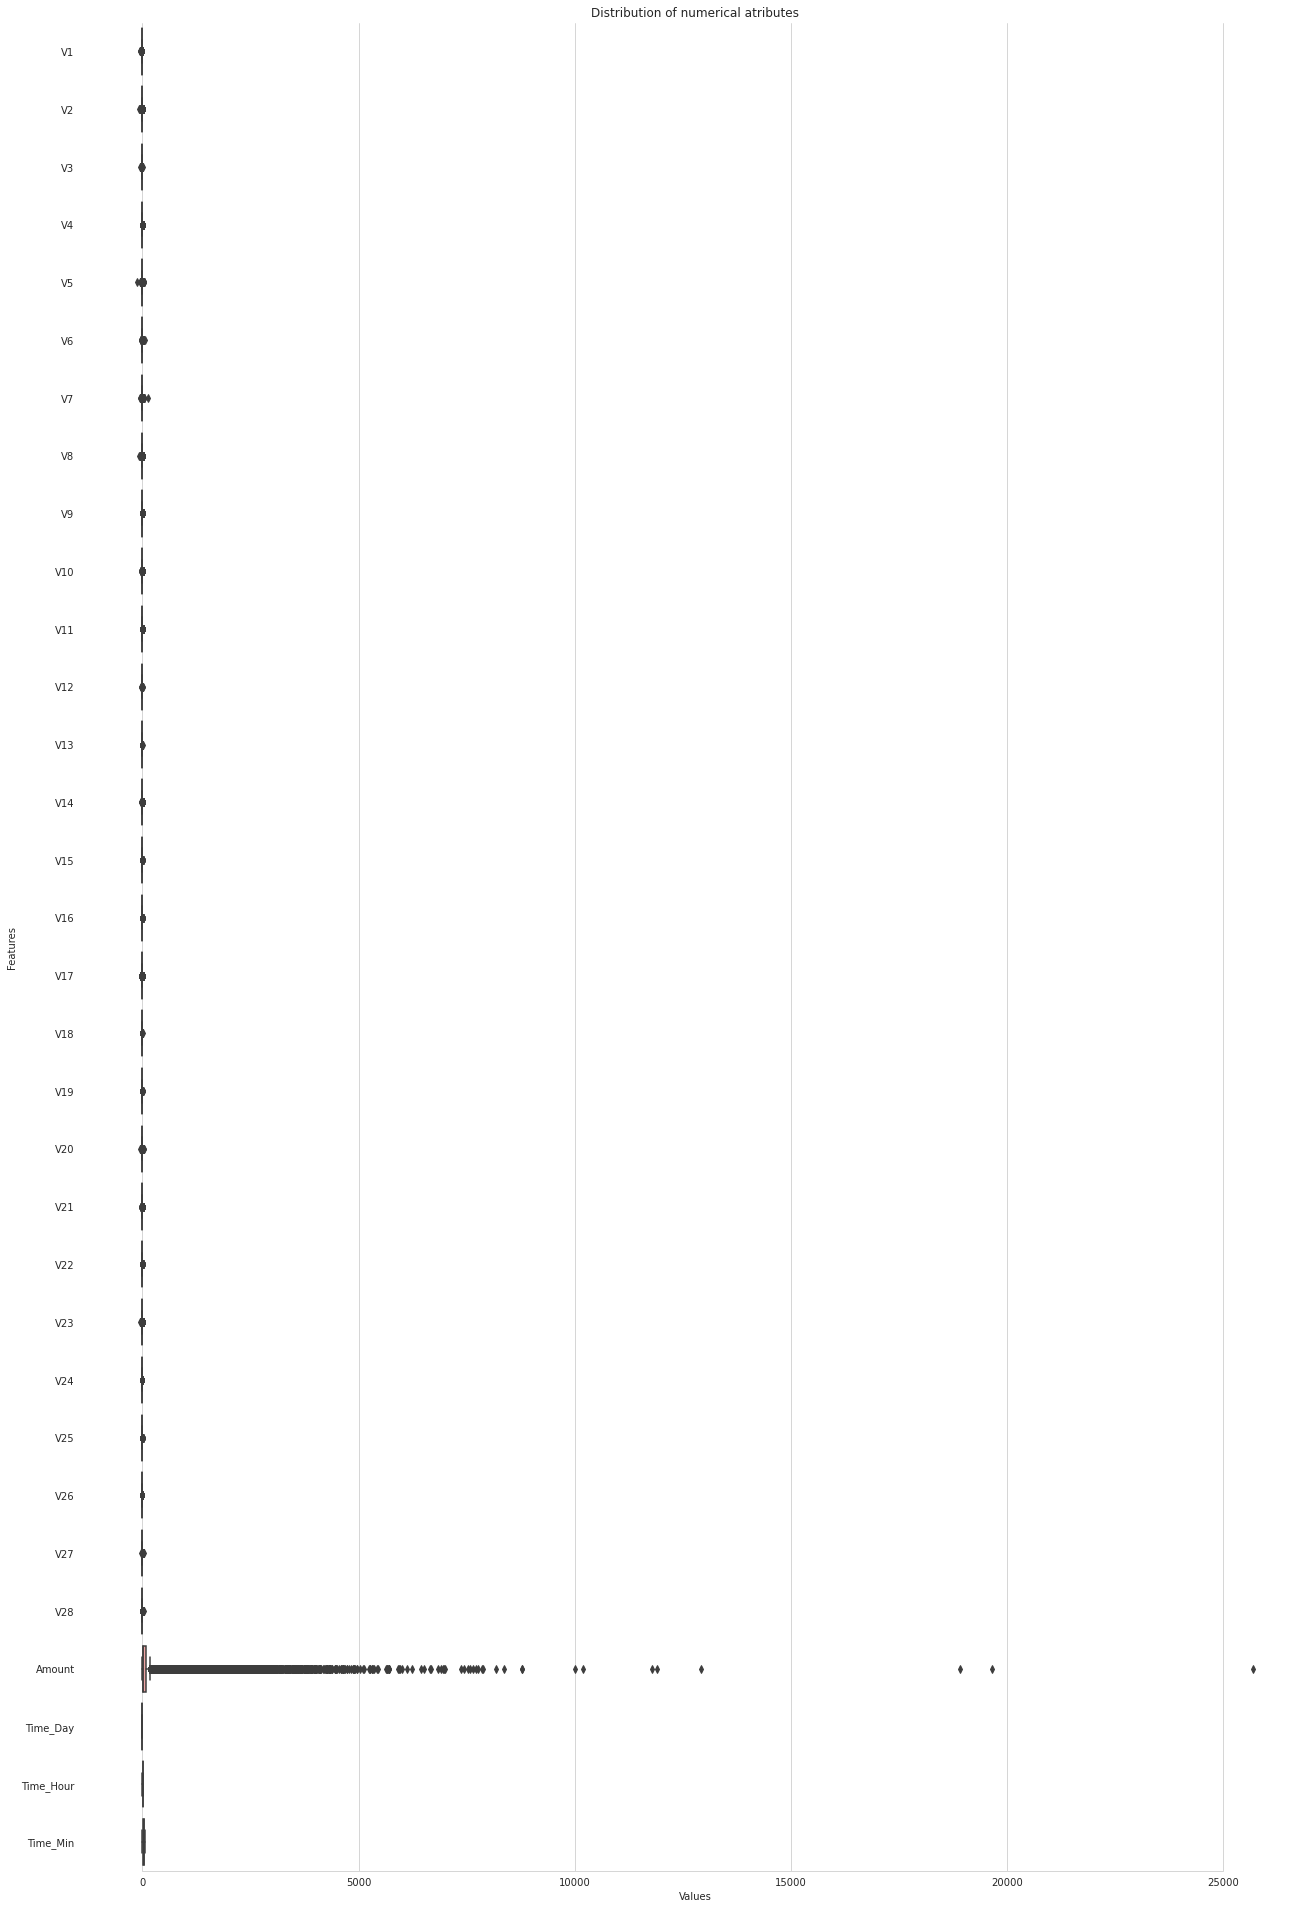

In [36]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluding BINARY target feature and Time variable as its not needed for transformation : 
li_not_plot = ['Class','Time']
li_transform_num_feats = [c for c in list(numeric_features) if c not in li_not_plot]

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(22,34))

ax = sns.boxplot(data=df[li_transform_num_feats] , orient="h", palette="Paired")
ax.set(ylabel="Features")
ax.set(xlabel="Values")
ax.set(title="Distribution of numerical atributes")
sns.despine(trim=True,left=True)

# Drop unnecessary columns
### Time column was further divided into hour, day, min. Lets drop the columns Time, hour, min

In [37]:
df.drop(['Time_Day', 'Time_Min', 'Time'], axis = 1, inplace= True)

### Splitting the data into train & test data

In [38]:
# Create X & Y dataset
X = df.drop(['Class'], axis=1)
y = df['Class']

In [39]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [40]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


### Plotting the distribution of a variable

In [42]:
cols = list(X.columns.values)
cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Time_Hour']

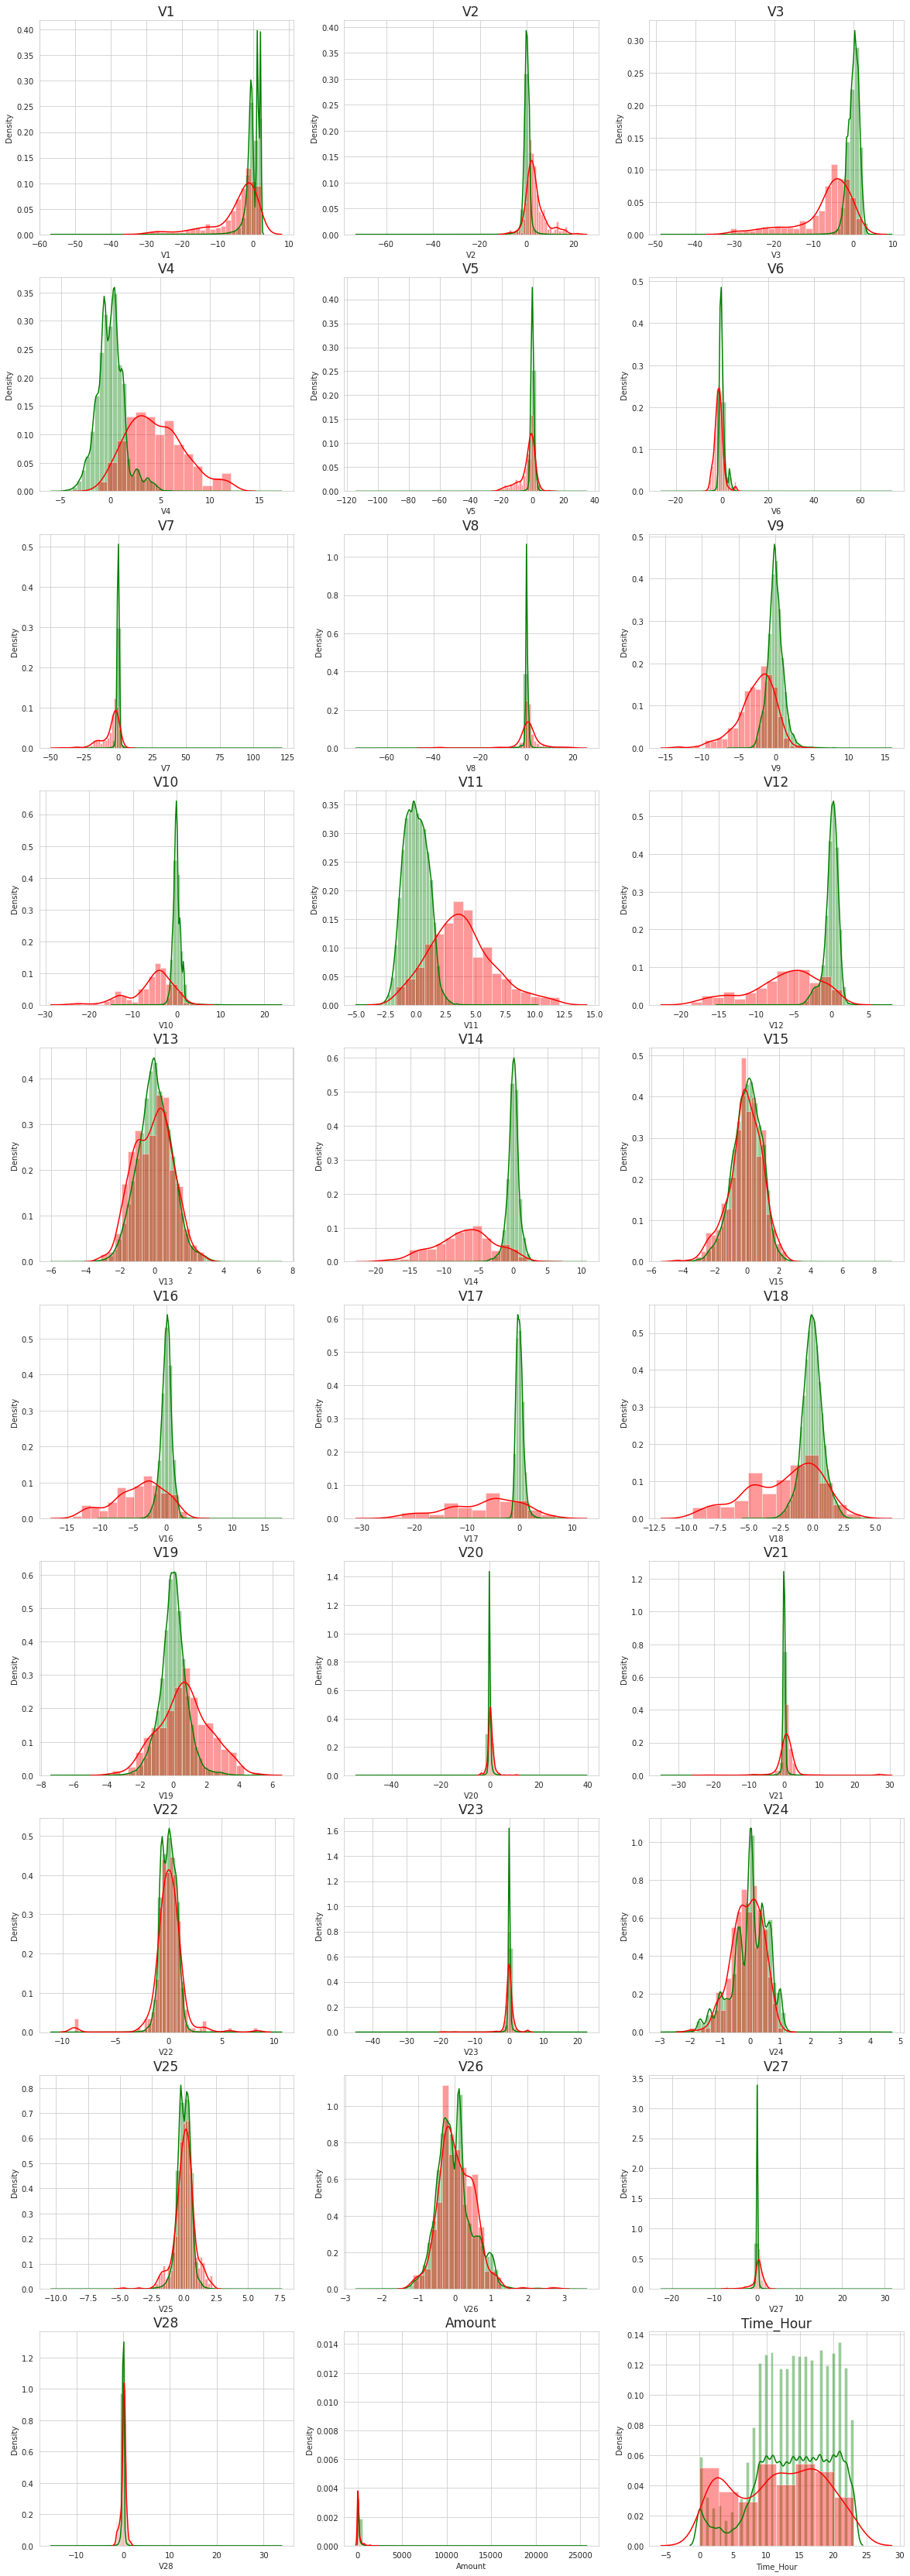

In [44]:
# plot the histogram of a variable from the dataset to see the skewness

normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color='red')
  plt.title(col, fontsize=17)
plt.show()

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [ ]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data

In [ ]:
# plot the histogram of a variable from the dataset again to see the result 

## Model Building
- Build different models on the imbalanced dataset and see the result

In [ ]:
# Logistic Regression
from sklearn import linear_model #import the package

num_C = ______  #--> list of values
cv_num =   #--> list of values

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

In [ ]:
#perform cross validation

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
clf = ___  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train)
print --> #print the evaluation score on the X_test by choosing the best evaluation metric

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

In [ ]:
# Logistic Regression
from sklearn import linear_model #import the package

num_C = ______  #--> list of values
cv_num =   #--> list of values

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

### Random Oversampling

In [ ]:
from imblearn import over_sampling #- import the packages

#perform cross validation & then balance classes on X_train_cv & y_train_cv using Random Oversampling

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### Print the class distribution after applying SMOTE 

In [ ]:
import warnings
warnings.filterwarnings("ignore")


sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using SMOTE

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using ADASYN

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


##### Build models on other algorithms to see the better performing on ADASYN

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
# perform the best oversampling method on X_train & y_train

clf = ___  #initialise the model with optimum hyperparameters
clf.fit( ) # fit on the balanced dataset
print() --> #print the evaluation score on the X_test by choosing the best evaluation metric

### Print the important features of the best model to understand the dataset

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [ ]:
print('Train auc =', metrics.roc_auc_score(_________)
fpr, tpr, thresholds = metrics.roc_curve(_________)
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)